In [591]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

CONFIG

In [614]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "nFeatures": 5,
        "dropout": 0.4,
        "lossFunc": "huber_loss", #Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "NVDA", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.3, # percentage of training data to be used as validation
        "testSize": 0.2, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}


Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

if the computer being used is an silicon apple chip then for tensorflow the following must be done

conda install -c apple tensorflow-deps
pip install tensorflow-macos
pip install tensorflow-metal # this is an optional but recommended

pip install pandas numpy matplotlib yahoo_fin scikit-learn

python -m pip install jupyter notebook -U

conda install -c conda-forge -y pandas jupyter


In [593]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [594]:
# create a model using the options in CONFIG
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

# display the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 50, 256)           268288    
                                                                 
 dropout_22 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_23 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________


Visualisze the model

In [595]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [596]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def setupData(
    ticker,
    offset,
    lookback = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predictiveRange = 2, # the number of days ahead that you are tyring to predict
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()

    # Get the data
    # data = yf.download(ticker, startDate, endDate)
    stocks = stock_info.get_data(ticker, startDate, endDate)

    # display how many days of data are being used for this
    print(f"Data is imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    print(f"Each day contains the prices for: {stocks.columns}")

    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    # check that all the inputs exist
    # for input in inputs:
    #     assert input in dataFrame.columns, f"'{input}' does not exist in the dataframe."
    
    # add a date column onto our data frame
    if "date" not in stocks.columns:
        stocks["date"] = stocks.index
    
    # THIS WHOLE THING NEEDS TO BE CHANGED
    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            scaler = preprocessing.MinMaxScaler()
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create the real value that needs to be predicted
    stocks["realExpected"] = stocks["adjclose"].shift(-predictiveRange)
    """THIS NEEDS TO BE REDONE IN A BETTER WAY"""
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(stocks[inputs].tail(predictiveRange))
    # drop NaNs
    stocks.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=lookback)
    # for entry, target in zip(stocks[inputs + ["date"]].values, stocks['realExpected'].values):
    for entry, target in zip(stocks[inputs].values, stocks['realExpected'].values):
        sequences.append(entry)
        if len(sequences) == lookback:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(inputs)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    data["last_sequence"] = last_sequence
    """ALL OF THE ABOVE NEEDS TO BE CHANGED"""

    # create lists of X (5 inputs) and y (1 output)
    x, y = [], []
    for seq, target in sequence_data:
        x.append(seq)
        y.append(target)

    # convert to numpy arrays
    x = np.array(x)
    y = np.array(y)
    print(x.size)
    for i in x:
        print(i)



    

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    train_samples = int((1 - testSize) * len(x))
    data["xtrain"] = x[:train_samples]
    data["ytrain"] = y[:train_samples]
    data["xtest"]  = x[train_samples:]
    data["ytest"]  = y[train_samples:]

    data["xlast10"] = x[int(len(x)-20):]
    data["xlast10"] = data["xlast10"][:, :, :len(inputs)].astype(np.float32)
    data["ylast10"] = y[int(len(x)-20):]

    # get the list of test set dates
    dates = data["xtest"][:, -1, -1]

    # retrieve test features from the original dataframe
    # data["test_df"] = data["df"].loc[dates]
    # # remove duplicated dates in the testing dataframe
    # data["test_df"] = data["test_df"][~data["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    data["xtrain"] = data["xtrain"][:, :, :len(inputs)].astype(np.float32)
    data["xtest"] = data["xtest"][:, :, :len(inputs)].astype(np.float32)


    # return the stocks that have been downloaded
    return data

# the number of years, months and days that you want to download
timeOffset = pd.DateOffset(
    years = 3,  
    months = 0,
    days = 0
    )

# Set the ticker
# ticker = "TSLA"
ticker = "AMZN"

data = setupData(ticker, timeOffset, scale = 0)

print(f"\n{data.keys()}\n\nHere are the adjusted values downloaded:")
print(data.keys())
print(data["raw"]["adjclose"].tail(10))
# print(data["raw"])

Data is imported between 2020-02-21 and the 2023-02-21, for a total of 755 days of data
Each day contains the prices for: Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')
176000
[[1.04798500e+02 9.29260000e+07 1.07107498e+02 1.07227501e+02
  1.04400002e+02]
 [1.00464500e+02 1.30940000e+08 1.00158997e+02 1.01964996e+02
  9.93984985e+01]
 [9.86370010e+01 1.24382000e+08 1.01320999e+02 1.01730003e+02
  9.79209976e+01]
 [9.89794998e+01 1.04492000e+08 9.85139999e+01 1.00733498e+02
  9.80224991e+01]
 [9.42149963e+01 1.62880000e+08 9.67190018e+01 9.87500000e+01
  9.41380005e+01]
 [9.41875000e+01 1.89620000e+08 9.07314987e+01 9.44879990e+01
  9.05565033e+01]
 [9.76975021e+01 1.35234000e+08 9.53245010e+01 9.77255020e+01
  9.35000000e+01]
 [9.54495010e+01 1.50690000e+08 9.87685013e+01 9.98164978e+01
  9.44045029e+01]
 [9.87914963e+01 9.54580000e+07 9.73284988e+01 9.89000015e+01
  9.60999985e+01]
 [9.62014999e+01 9.49640000e+07 9.66500015e+01 9.80360031e+01
 

BETTER DATA LOADER

In [597]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"Data is imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize) * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]
    data["xtest"]  = x[trainSamples:]
    data["ytest"]  = y[trainSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["testDates"] = ydates[trainSamples:]

    return data

In [615]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])
stocks.keys()

Data is imported between 2020-02-21 and the 2023-02-21, for a total of 755 days of data
Each day contains the prices for: Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [616]:
# process the data
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

print(f"{data.keys()}\n\nHere are the adjusted values downloaded:")

print(data.keys())

print(len(data["raw"]))
print(len(data["ydates"]))


dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xtest', 'ytest', 'trainDates', 'testDates'])

Here are the adjusted values downloaded:
dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xtest', 'ytest', 'trainDates', 'testDates'])
755
704


Plot the data imported form the stocks

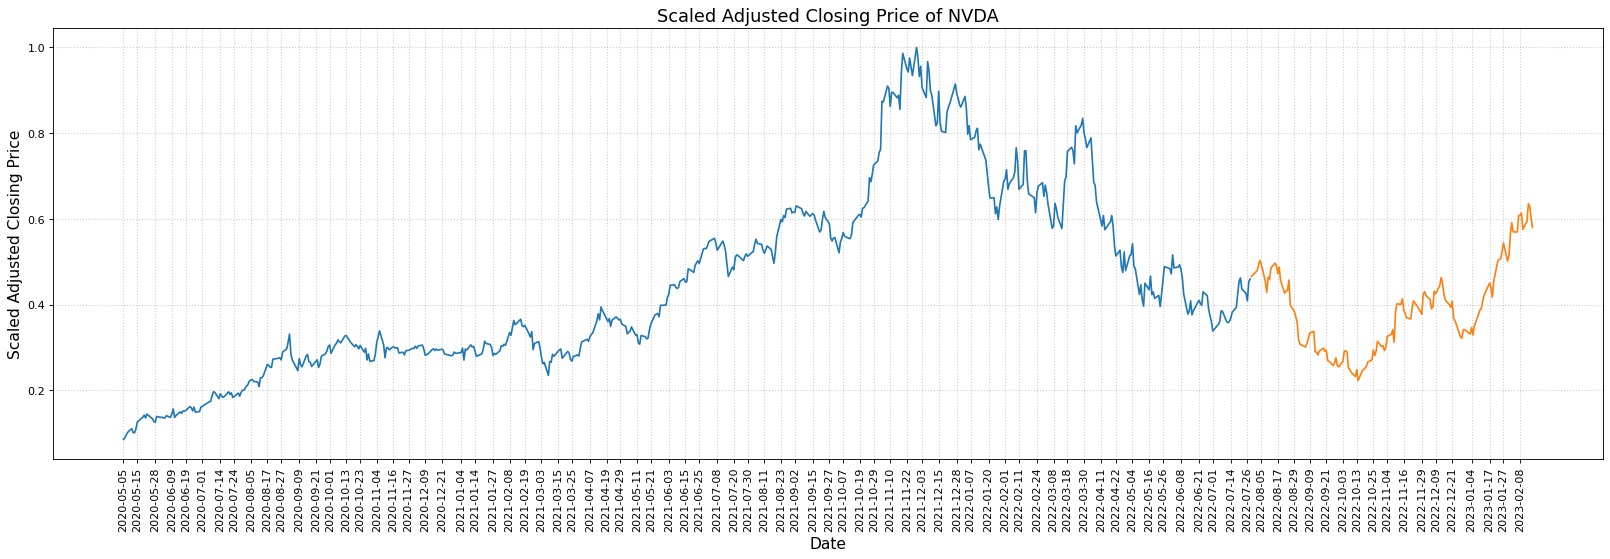

In [651]:
import matplotlib.pyplot as plt

plots = "trainDates ytrain,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else None
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
# show the plot
plt.show()


Train the model

pip install tensorflow-macos==2.10
pip install tensorflow-metal==0.6

In [792]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
model.fit(data["xtrain"], data["ytrain"],
                    batch_size=64,
                    epochs=500,
                    validation_data=(data["xtest"], data["ytest"]),
                    verbose=0) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Plot the results

18/18 [==============================] - 0s 18ms/step


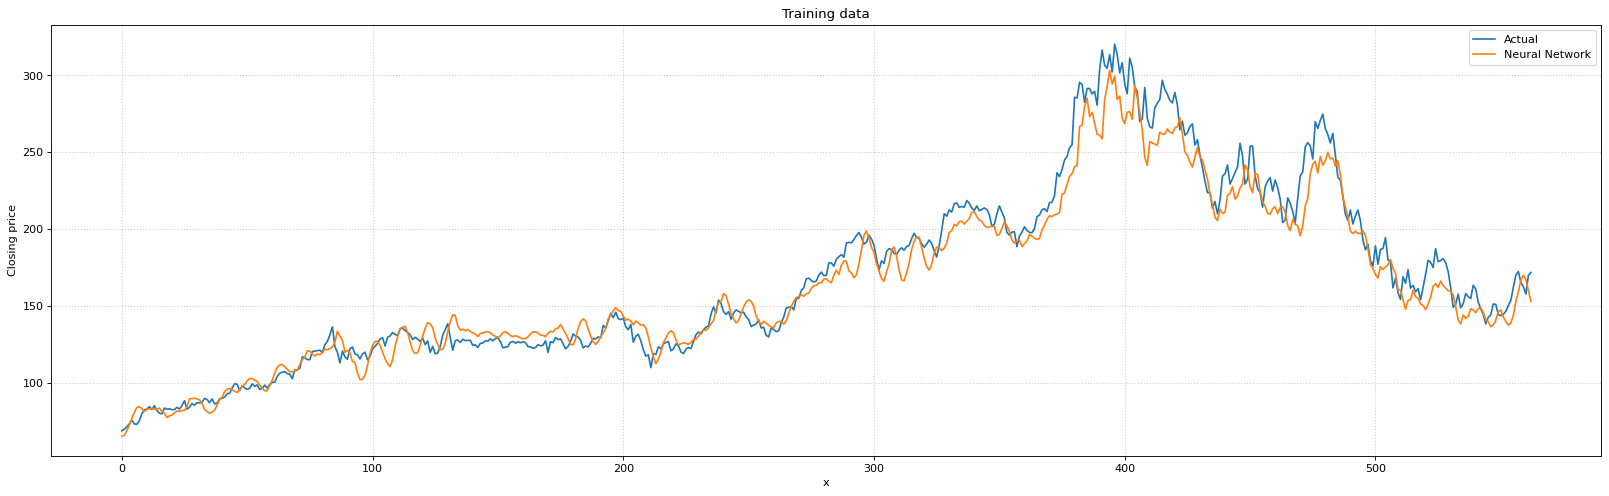

5/5 [==============================] - 0s 38ms/step


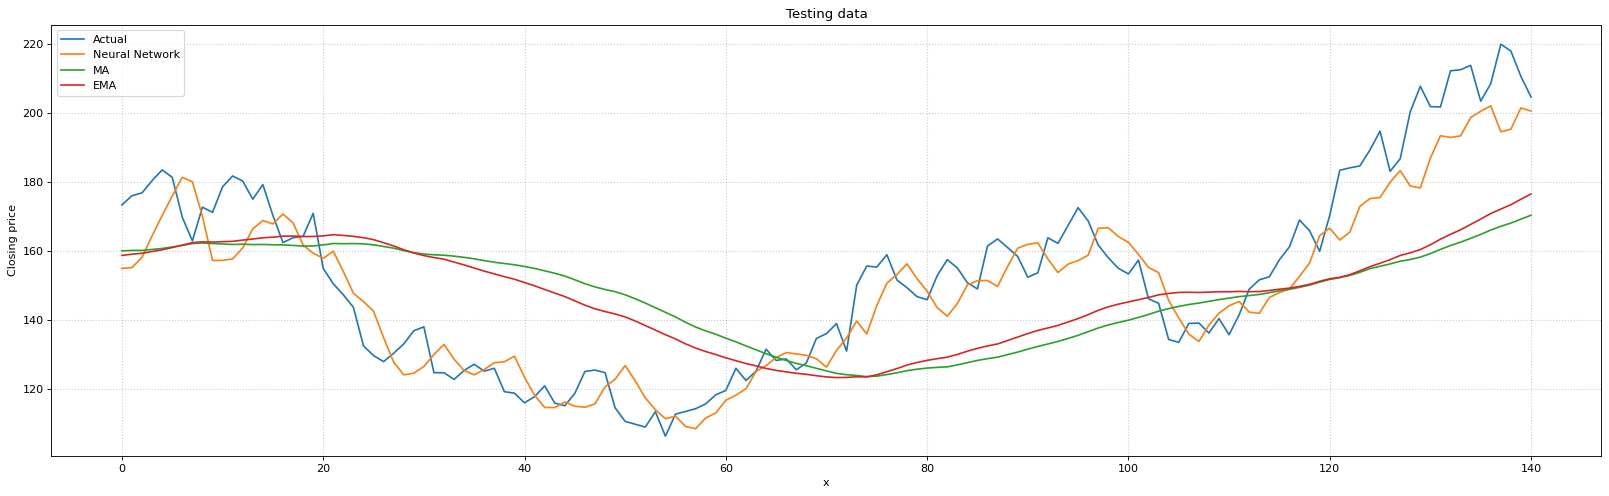

In [790]:

# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))
plt.plot(ytrain)
plt.plot(pred_ytrain)
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network".split(","))
plt.show()



# calcualte the price using a simple moving average
pred_MA = np.mean(data["xtest"], axis = 1)
pred_MA = pred_MA[:, 0] # take only the adjclose price out
pred_MA = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_MA, axis=0)))
# calculate the price using exponential moving average
pred_EMA = data["xtest"][:, :, 0] # only take the 
pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
weights = np.exp(np.linspace(-1, 0, config["nn"]["window"]))
weights /= weights.sum()
pred_EMA = pred_EMA@weights



# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
plt.plot(ytest) # actual data
plt.plot(pred_ytest) # prediction made by neural network
plt.plot(pred_MA)
plt.plot(pred_EMA)
plt.title("Testing data")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network,MA,EMA".split(","))
plt.show()



 RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [789]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100
    return mape

print("Training options")
print(calculate_rmse(ytrain, pred_ytrain))
print(calculate_mape(ytrain, pred_ytrain))
print("\nTesting options")
print(calculate_rmse(ytest, pred_ytest))
print(calculate_mape(ytest, pred_ytest))
print("\nTesting options MA")
print(calculate_rmse(ytest, pred_MA))
print(calculate_mape(ytest, pred_MA))
print("\nTesting options EMA")
print(calculate_rmse(ytest, pred_EMA))
print(calculate_mape(ytest, pred_EMA))

Training options
12.489383630854725
5.199362526706609

Testing options
10.603447307658147
5.491691339691082

Testing options MA
26.440124613359483
15.333301273876382

Testing options EMA
24.073513454789314
13.90052140474907
